# Syntactic Knowledge Acquisition

## SUBJECT-VERB AGREEMENT

In [1]:
import logging
import pandas as pd
import pickle
from matplotlib import pyplot as plt
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForMaskedLM

# suppress warnings
logging.getLogger("transformers").setLevel(logging.ERROR)

/home/nshafiabadi/anaconda3/envs/virtualenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
def evaluate(sentence, word, checkpoint):
    """
    - INPUT: 
        sentence: a sentence with a masked token w
        word: the target label for the masked token
        checkpoint: a pretrained model checkpoint
    - OUTPUT: probability and surprisal of the target at the masked position 
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    tokenizer = AutoTokenizer.from_pretrained(checkpoint)
    model = AutoModelForMaskedLM.from_pretrained(checkpoint).to(device)

    if torch.cuda.device_count() > 1:
        model = torch.nn.DataParallel(model)

    inputs = tokenizer(sentence, return_tensors='pt').to(device)
    label_id = tokenizer.convert_tokens_to_ids(word)
    
    model.eval()
    with torch.no_grad():
        logits = model(**inputs).logits
    
    probs = F.softmax(logits, dim=-1)

    # probability and surprisal of the target at the masked position
    mask_token_index = torch.where(inputs['input_ids'][0] == tokenizer.mask_token_id)[0]
    label_prob = probs[0, mask_token_index, label_id].item()    
    surprisal = -torch.log2(label_prob).item()

    return label_prob, surprisal

In [3]:
def word_evaluation(sentence_pair, sent_id, model, df, description=''):
    """
    INPUT:
        - sentence_pair: a tuple of tokenized strings
        - model: a Google Multiberts model from Hugging Face
    OUTPUT:
        - a Pandas data frame containing the probability of the label and surprisal of the model at each step
    """
    sent_1, sent_2 = sentence_pair

    # extracting the different words as the labels
    label_1 = ''.join(filter(lambda word: word not in sent_2.split(), sent_1.split()))
    label_2 = ''.join(filter(lambda word: word not in sent_1.split(), sent_2.split()))

    masked_sent = ' '.join('[MASK]' if word == label_1 else word for word in sent_1.split())

    steps = list(range(0, 200_000, 20_000)) + list(range(200_000, 2_100_000, 100_000))
    for step in steps:
        checkpoint = model + f'-step_{step//1000}k'
        for label in [label_1, label_2]:
            probability, surprisal = evaluate(masked_sent, label, checkpoint)
            label_data = {'step': step,
                          'sent_id': sent_id, 
                          'masked_sent': masked_sent, 
                          'label': label,
                          'correct': label == label_1,  # the first label is the correct label 
                          'probability': probability, 
                          'surprisal': surprisal,
                          'description': description}        
            df = df.append(label_data, ignore_index=True)

    return df

In [4]:
def corpus_evaluation(data_df, model):
    results_df = pd.DataFrame(columns=['step', 'sent_id', 'masked_sent', 'label', 'correct', 'probability', 'surprisal'])
    sent_id = 0
    for column in data_df.columns:
        for sentence_pair in data_df[column].tolist():
            results_df = word_evaluation(sentence_pair, sent_id, model, results_df, description=column)
            sent_id += 1
    return results_df

In [5]:
def plot_single_pair(df):
    plt.style.use('ggplot')
    fig, axs = plt.subplots(2, figsize=(8, 8))

    labels = df['label'].unique().tolist()

    for label in labels:
        # plot for surprisals
        df[df['label'] == label].plot(x='step', y='surprisal', logx=True, title='Surprisal', ax=axs[0], label=label)

        # plot for probabilities
        df[df['label'] == label].plot(x='step', y='probability', logx=True, title='Probability', ax=axs[1], label=label)

    axs[0].legend()
    axs[1].legend()

    plt.tight_layout()
    plt.show()

In [6]:
def plot_full_corpus(df):
    plt.style.use('ggplot')
    fig, axs = plt.subplots(2, figsize=(9, 6))

    df = df.sort_values('step')
    correct = df[df['correct'] == True]
    incorrect = df[df['correct'] == False]

    # plot for probabilities
    correct.plot(x='step', y='probability', logx=True, kind='scatter', color='green', alpha=0.2, ax=axs[0], label='individual correct')
    correct.groupby('step').probability.mean().plot(x='step', ylabel='probability', logx=True, color='green', linestyle='--', ax=axs[0], label='average correct', title='Probability of Correct vs Incorrect Labels')
    incorrect.plot(x='step', y='probability', logx=True, kind='scatter', color='red', alpha=0.2, ax=axs[0], label='individual incorrect')
    incorrect.groupby('step').probability.mean().plot(x='step', ylabel='probability', logx=True, color='red', linestyle='--', ax=axs[0], label='average incorrect')

    # plot for surprisals
    correct.plot(x='step', y='surprisal', logx=True, kind='scatter', color='green', alpha=0.2, ax=axs[1], label='individual correct')
    correct.groupby('step').surprisal.mean().plot(x='step', ylabel='surprisal', logx=True, color='green', linestyle='--', ax=axs[1], label='average correct', title='Surprisal of Correct vs Incorrect Labels')
    incorrect.plot(x='step', y='surprisal', logx=True, kind='scatter', color='red', alpha=0.2, ax=axs[1], label='individual incorrect')
    incorrect.groupby('step').surprisal.mean().plot(x='step', ylabel='surprisal', logx=True, color='red', linestyle='--', ax=axs[1], label='average incorrect')

    axs[0].legend(loc='upper left', bbox_to_anchor=(1.0, 1))
    axs[1].legend(loc='upper left', bbox_to_anchor=(1.0, 1))

    # plt.grid('--')
    plt.tight_layout()
    plt.show()

In [7]:
def plot_full_corpus(df):
    plt.style.use('ggplot')
    fig, axs = plt.subplots(2, figsize=(9, 7))

    df = df.sort_values('step')
    correct = df[df['correct'] == True]
    incorrect = df[df['correct'] == False]

    # plot for probabilities
    correct.plot(x='step', y='probability', logx=True, kind='scatter', color='green', alpha=0.2, ax=axs[0], label='individual correct')
    correct.groupby('step').probability.mean().plot(x='step', ylabel='probability', logx=True, color='green', linestyle='--', ax=axs[0], label='average correct', title='Probability of Correct vs Incorrect Labels')
    incorrect.plot(x='step', y='probability', logx=True, kind='scatter', color='red', alpha=0.2, ax=axs[0], label='individual incorrect')
    incorrect.groupby('step').probability.mean().plot(x='step', ylabel='probability', logx=True, color='red', linestyle='--', ax=axs[0], label='average incorrect')

    # plot for surprisals
    correct.plot(x='step', y='surprisal', logx=True, kind='scatter', color='green', alpha=0.2, ax=axs[1], label='individual correct')
    correct.groupby('step').surprisal.mean().plot(x='step', ylabel='surprisal', logx=True, color='green', linestyle='--', ax=axs[1], label='average correct', title='Surprisal of Correct vs Incorrect Labels')
    incorrect.plot(x='step', y='surprisal', logx=True, kind='scatter', color='red', alpha=0.2, ax=axs[1], label='individual incorrect')
    incorrect.groupby('step').surprisal.mean().plot(x='step', ylabel='surprisal', logx=True, color='red', linestyle='--', ax=axs[1], label='average incorrect')

    axs[0].legend(loc='upper left', bbox_to_anchor=(1.0, 1))
    axs[1].legend(loc='upper left', bbox_to_anchor=(1.0, 1))

    # plt.grid('--')
    plt.tight_layout()
    plt.show()

In [8]:
def plot_proportion_correct(df):
    """ 
    Measures the syntactic ability of the model by comparing the probabilities 
    assigned to the singular and plural variants of the target and plotting 
    the percentage of sentences for which the verb form with the higher 
    probability is the one that respects the agreement rules of the language.
    (Li et al. (2023))
    """
    proportion_df = (df.pivot_table(index=['step', 'sent_id'], columns='correct', values='probability')
                    .reset_index()
                    .rename(columns={False: 'prob_incorrect', True: 'prob_correct'})
                    .assign(correct_higher=lambda x: x['prob_correct'] > x['prob_incorrect'])
                    .groupby('step')['correct_higher']
                    .mean()
                    .reset_index()
                    .rename(columns={'correct_higher': 'proportion'}))

    plt.style.use('ggplot')
    plt.figure(figsize=(8, 4))
    plt.plot(proportion_df['step'] + 10000, proportion_df['proportion'], marker='o')
    plt.xlabel('Step')
    plt.ylabel('Proportion')
    plt.title('Proportion of Correct Form Having Higher Probability Over Steps')
    plt.xscale('log')
    plt.show()

In [9]:
def unmask(sentence, checkpoint):
    """ Currently useless """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    tokenizer = AutoTokenizer.from_pretrained(checkpoint)
    model = AutoModelForMaskedLM.from_pretrained(checkpoint).to(device)

    if torch.cuda.device_count() > 1:
        model = torch.nn.DataParallel(model)

    inputs = tokenizer(sentence, add_special_tokens=False, return_tensors='pt').to(device)
    masked_idx = torch.where(inputs['input_ids'] == tokenizer.mask_token_id)[1]
    
    model.eval()
    with torch.no_grad():
        logits = model(**inputs).logits
    
    probs = F.softmax(logits[0, masked_idx.item(), :], dim=-1)
    top_ids = torch.argsort(probs, axis=-1, descending=True)[:5]
    top_tokens = [tokenizer.convert_ids_to_tokens(id.item()) for id in top_ids]
    top_token_probs = probs[top_ids]

    for token, prob in zip(top_tokens, top_token_probs):
        print(f'Token: {token}, Probability: {prob}')

    return 

---

### Simple Agreement

In [11]:
with open('sample_data/lm_syneval/simple_agrmt.pickle', 'rb') as f:
    simple_agrmt = pd.DataFrame(pickle.load(f))

simple_agrmt

,sing_MS_MV,plur_MS_MV
0,"(the author laughs, the author laugh)","(the authors laugh, the authors laughs)"
1,"(the author swims, the author swim)","(the authors swim, the authors swims)"
2,"(the author smiles, the author smile)","(the authors smile, the authors smiles)"
3,"(the author is tall, the author are tall)","(the authors are tall, the authors is tall)"
4,"(the author is old, the author are old)","(the authors are old, the authors is old)"
...,...,...
65,"(the consultant smiles, the consultant smile)","(the consultants smile, the consultants smiles)"
66,"(the consultant is tall, the consultant are tall)","(the consultants are tall, the consultants is ..."
67,"(the consultant is old, the consultant are old)","(the consultants are old, the consultants is old)"
68,"(the consultant is young, the consultant are y...","(the consultants are young, the consultants is..."


In [ ]:
%%time 

model = 'google/multiberts-seed_0'
results_df = corpus_evaluation(simple_agrmt, model)
results_df.to_csv('results/simple_agrmt_results.csv', sep='\t', index=False)

#### Results Analysis

In [7]:
results_df = pd.read_csv('results/simple_agrmt_results.csv', sep='\t')

# in every sentence pair (same sent_id) the first label is the correct label. 
results_df.insert(results_df.columns.get_loc('label') + 1, 'correct', results_df.groupby(['step', 'sent_id']).cumcount() % 2 == 0)
results_df

,step,sent_id,masked_sent,label,correct,probability,surprisal,description
0,0,0,the author [MASK],laughs,True,1.048201e-05,16.541725,sing_MS_MV
1,0,0,the author [MASK],laugh,False,5.473720e-05,14.157119,sing_MS_MV
2,20000,0,the author [MASK],laughs,True,7.257230e-07,20.394077,sing_MS_MV
3,20000,0,the author [MASK],laugh,False,3.766840e-07,21.340141,sing_MS_MV
4,40000,0,the author [MASK],laughs,True,6.418337e-06,17.249369,sing_MS_MV
...,...,...,...,...,...,...,...,...
8115,1800000,139,the consultants [MASK] short,is,False,8.593616e-03,6.862519,plur_MS_MV
8116,1900000,139,the consultants [MASK] short,are,True,6.057420e-02,4.045153,plur_MS_MV
8117,1900000,139,the consultants [MASK] short,is,False,4.686356e-03,7.737318,plur_MS_MV
8118,2000000,139,the consultants [MASK] short,are,True,5.674843e-02,4.139276,plur_MS_MV


['the surgeons [MASK] short']


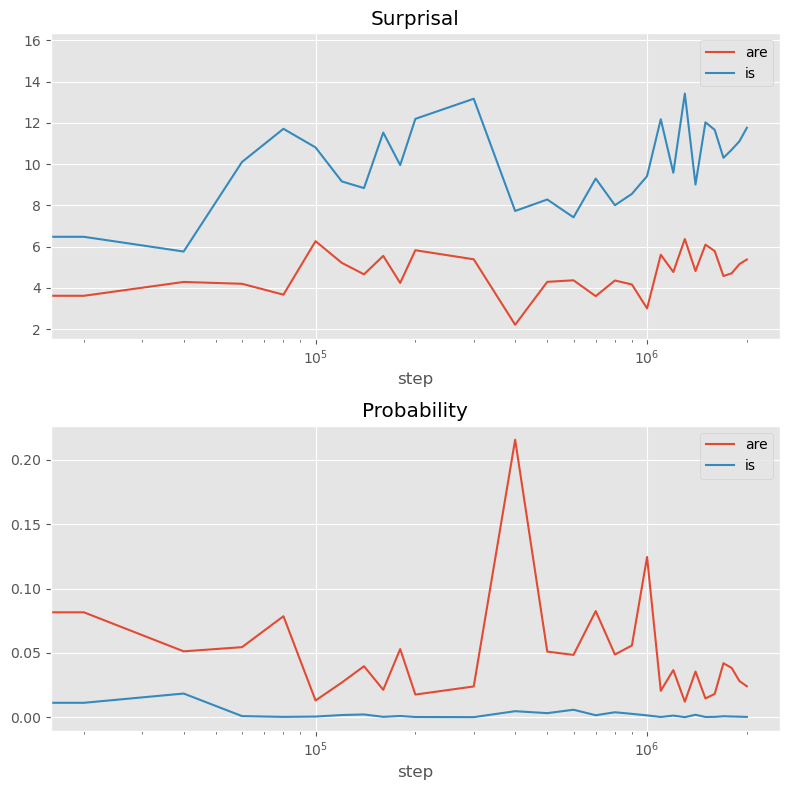

In [10]:
print(results_df[results_df['sent_id'] == 90]['masked_sent'].unique())
plot_single_pair(results_df[results_df['sent_id'] == 90])

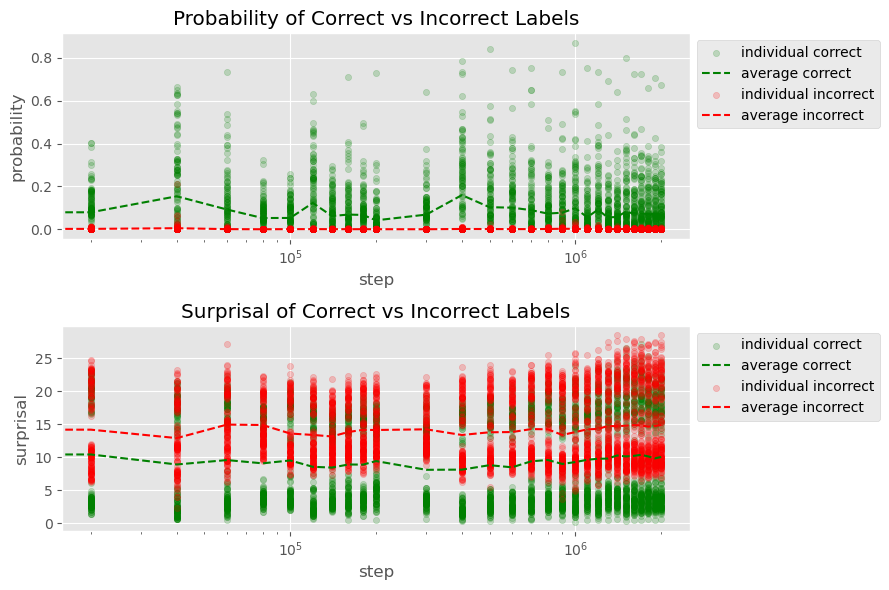

In [17]:
plot_full_corpus(results_df)

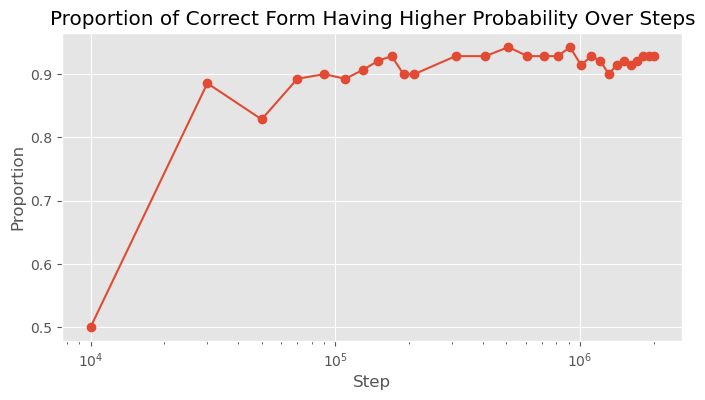

In [94]:
plot_proportion_correct(results_df)

In [199]:
import random

sentence = random.choice(results_df['masked_sent'])
print(sentence)

unmask(sentence, 'google/multiberts-seed_0-step_2000k')

the senators [MASK] short
cpu
Token: short, Probability: 0.13139919936656952
Token: :, Probability: 0.13121311366558075
Token: ', Probability: 0.10583637654781342
Token: -, Probability: 0.0676347091794014
Token: ,, Probability: 0.036891285330057144


---

### In a sentential complement

In [10]:
with open('sample_data/lm_syneval/sent_comp.pickle', 'rb') as f:
    sent_comp = pd.DataFrame(pickle.load(f))

sent_comp

,sing_MS_MV_sing_BS,sing_MS_MV_plur_BS,plur_MS_MV_sing_BS,plur_MS_MV_plur_BS
0,"(the mechanic said the author laughs, the mech...","(the mechanics said the author laughs, the mec...","(the mechanic said the authors laugh, the mech...","(the mechanics said the authors laugh, the mec..."
1,"(the mechanic said the author swims, the mecha...","(the mechanics said the author swims, the mech...","(the mechanic said the authors swim, the mecha...","(the mechanics said the authors swim, the mech..."
2,"(the mechanic said the author smiles, the mech...","(the mechanics said the author smiles, the mec...","(the mechanic said the authors smile, the mech...","(the mechanics said the authors smile, the mec..."
3,"(the mechanic said the author is tall, the mec...","(the mechanics said the author is tall, the me...","(the mechanic said the authors are tall, the m...","(the mechanics said the authors are tall, the ..."
4,"(the mechanic said the author is old, the mech...","(the mechanics said the author is old, the mec...","(the mechanic said the authors are old, the me...","(the mechanics said the authors are old, the m..."
...,...,...,...,...
415,"(the banker knew the consultant smiles, the ba...","(the bankers knew the consultant smiles, the b...","(the banker knew the consultants smile, the ba...","(the bankers knew the consultants smile, the b..."
416,"(the banker knew the consultant is tall, the b...","(the bankers knew the consultant is tall, the ...","(the banker knew the consultants are tall, the...","(the bankers knew the consultants are tall, th..."
417,"(the banker knew the consultant is old, the ba...","(the bankers knew the consultant is old, the b...","(the banker knew the consultants are old, the ...","(the bankers knew the consultants are old, the..."
418,"(the banker knew the consultant is young, the ...","(the bankers knew the consultant is young, the...","(the banker knew the consultants are young, th...","(the bankers knew the consultants are young, t..."
